# 決定木を使ったbitcoinの値上り予測
## 環境設定

In [6]:
# django
MYPROJECT = '/home/notebooks'
import os, sys
sys.path.insert(0, MYPROJECT)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")
import django
django.setup()
from bot.models import Exchange

# matplotlib
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib.ticker as ticker
import sqlite3
from django_pandas.io import read_frame
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 12
import numpy as np

# timezone
from datetime import datetime, timedelta
from django.utils import timezone
import pytz
timezone.now()
first_date = datetime(2018, 6, 20, tzinfo=pytz.UTC)
last_date = datetime(2018, 6, 21, tzinfo=pytz.UTC)

def make_subset(exchange: Exchange, first_date: datetime, last_date: datetime) -> pd.DataFrame:
    ex = Exchange.objects \
        .filter(name=exchange, created_at__range=(first_date, last_date)) \
        .extra(select={'time': "strftime('%%Y-%%m-%%d %%H:%%M', created_at)"}) \
        .values('time', 'btc_jpy_bid', 'btc_jpy_ask', 'created_at') \
        .order_by('time')
    rf = read_frame(ex, index_col='time')
    rf = rf[~rf.index.duplicated(keep='first')]
    rf.index = pd.to_datetime(rf.index)
    return rf.resample('T').fillna(method='ffill')

In [5]:
from sklearn.tree import DecisionTreeClassifier

ModuleNotFoundError: No module named 'sklearn'

## BitCoinのリターンインデックス作成

In [3]:
cc = make_subset(Exchange.CC, first_date, last_date)
returns = pd.Series(cc['btc_jpy_bid'].astype(float)).pct_change()
return_index = (1 + returns).cumprod()
return_index[0] = 1
return_index[:4]

time
2018-06-20 00:00:00    1.000000
2018-06-20 00:01:00    1.000000
2018-06-20 00:02:00    0.999891
2018-06-20 00:03:00    1.000153
Freq: T, Name: btc_jpy_bid, dtype: float64

## sampleとfeatureの作成

In [64]:
NUMBER_SAMPLE = 30
NUMBER_FEATURE = 14
x_samples = []
y_samples = []
for i in np.arange(-NUMBER_SAMPLE, -NUMBER_FEATURE - 1):
    slice_number = i + NUMBER_FEATURE
    features = return_index.iloc[i:slice_number]
    if features[-1] <= return_index[slice_number]:
        y_samples.append('UP or KEEP')
    else:
        y_samples.append('DOWN')
    x_samples.append(features.values)
np.array(y_samples)

array(['DOWN', 'UP or KEEP', 'UP or KEEP', 'UP or KEEP', 'UP or KEEP',
       'UP or KEEP', 'DOWN', 'UP or KEEP', 'DOWN', 'UP or KEEP', 'DOWN',
       'UP or KEEP', 'DOWN', 'UP or KEEP', 'UP or KEEP'], dtype='<U10')

## classifierを作成

In [65]:
classifier = DecisionTreeClassifier()
classifier.fit(x_samples, y_samples)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 予測

In [66]:
first_date = datetime(2018, 6, 29, tzinfo=pytz.UTC)
last_date = datetime(2018, 6, 30, tzinfo=pytz.UTC)
cc = make_subset(Exchange.CC, first_date, last_date)
returns = pd.Series(cc['btc_jpy_bid'].astype(float)).pct_change()
return_index = (1 + returns).cumprod()
return_index[0] = 1
samples = [np.array(return_index[:NUMBER_FEATURE])]
result = classifier.predict(samples)
print(return_index[13:NUMBER_FEATURE].values[0])
print(return_index[NUMBER_FEATURE:15].values[0])
print(result[0])


1.0025533126476236
1.0025747433293182
UP or KEEP


## 決定木モデルの図

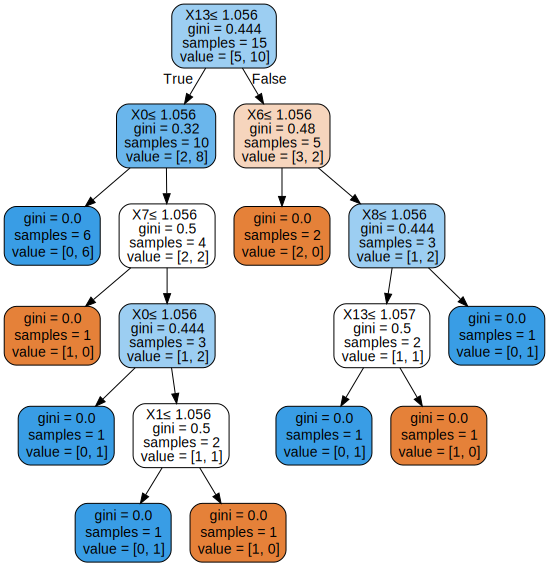

In [72]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(classifier, out_file=None)
graph = graphviz.Source(dot_data)
dot_data = tree.export_graphviz(classifier, out_file=None,
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph